# Using UMAP as a Classifier

### Following https://github.com/lmcinnes/umap/blob/master/doc/supervised.rst

In [30]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
#plt.rcParams['figure.figsize'] = (14, 12)
plt.rcParams['figure.figsize'] = (10, 10)
import seaborn as sns
sns.set(style='white', context='poster')

## Load MNIST Fashion data

In [2]:
import keras

from keras.datasets import fashion_mnist

(train, train_labels), (test, test_labels) = fashion_mnist.load_data()

Using TensorFlow backend.


In [3]:
print (train.shape)
print (test.shape)
print (train_labels.shape)
print (test_labels.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


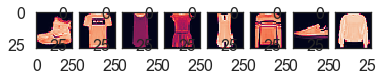

In [4]:
gs = gridspec.GridSpec(1,8)
for i in range(8):
    ax = plt.subplot(gs[0, i])
    ax.imshow(train[i])

In [5]:
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0

In [6]:
data.shape

(70000, 28, 28)

In [7]:
target = np.hstack([train_labels, test_labels])

In [8]:
target.shape

(70000,)

In [9]:
set(target)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [10]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

## Create embeddings with UMAP

In [11]:
import umap

In [12]:
data.shape

(70000, 28, 28)

In [13]:
# flatten and then reshape the data so we can run through UMAP
data_flat = data.flatten().reshape(70000, 784)
data_flat.shape

(70000, 784)

In [14]:
e = umap.UMAP(
    n_neighbors=5
    ).fit_transform(data_flat)

In [15]:
e.shape

(70000, 2)

In [31]:
def plot_e(embeddings):
    plt.scatter(embeddings[:,0], embeddings[:,1], c=target, cmap='Spectral', s=0.5)

    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)

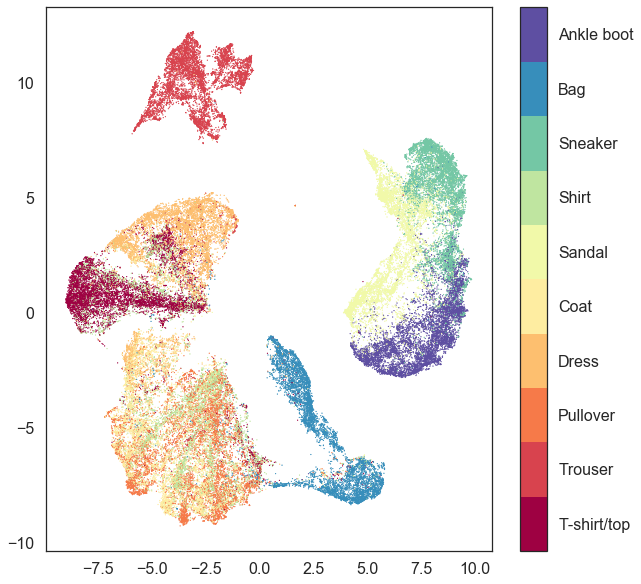

In [32]:
plot_e(e)

"Ideally we would like much better class separation. Since we have the label information we can actually give that to UMAP to use!"

- from https://github.com/lmcinnes/umap/blob/master/doc/supervised.rst

# Using Labels to Separate Classes (Supervised UMAP)

In [18]:
# use the y attribute of the fit_transform method
e2 = umap.UMAP(
    n_neighbors=5
    ).fit_transform(data_flat, y=target)

# NOTE:
# target would be our HDBSCAN labels from the previous run labelled by an expert as failure etc.
# use -1 if you don't know the target

In [19]:
e2.shape

(70000, 2)

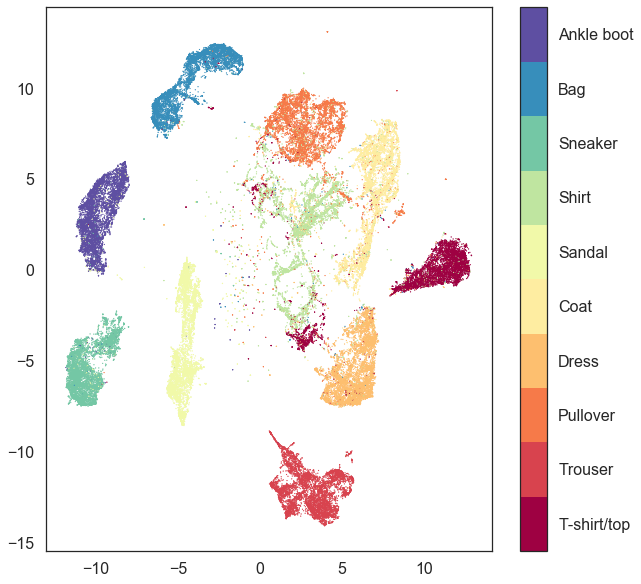

In [34]:
plot_e(e2)

## Using Partial-labelling (not knowning all of the modes and using only ones we know)

In [21]:
# set unknowns to the scikit standard of -1
masked_target = target.copy().astype(np.int8)
masked_target[np.random.choice(70000, size=10000, replace=False)] = -1

In [22]:
# use the y attribute of the fit_transform method
e3 = umap.UMAP(
    n_neighbors=5
    ).fit_transform(data_flat, y=masked_target)

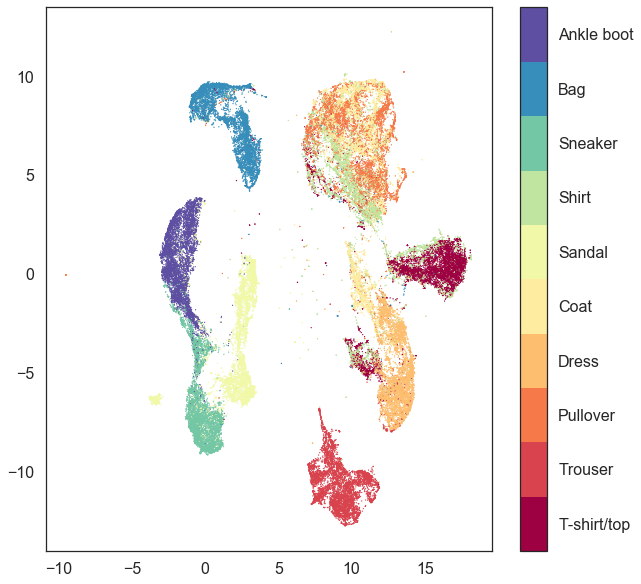

In [35]:
plot_e(e3)

## Find Embeddings of Unseen Data for Classification

In [24]:
train.shape

(60000, 28, 28)

In [25]:
# create trained UMAP model using only the training data
# and add the (known) labelled classes to supervise

# only supervise by known labels (for realism)
masked_train_target = train_labels.copy().astype(np.int8)
masked_train_target[np.random.choice(60000, size=10000, replace=False)] = -1

# prepare train data
train_flat = train.flatten().reshape(60000, 784)

# just use the fit method not fit_transform as we are creating a reusable model
umap_model = umap.UMAP(
    n_neighbors=5
    ).fit(train_flat, y=masked_train_target)

In [26]:
umap_model

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=5, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [27]:
# we can access the trained embeddings using the embedding_ method
umap_model.embedding_

array([[ 9.296695  , -1.4783562 ],
       [-8.976883  , -0.02757272],
       [-3.7965314 ,  2.1474924 ],
       ...,
       [-6.763012  ,  3.5994115 ],
       [-4.8196664 ,  0.5473419 ],
       [ 8.599002  ,  4.993602  ]], dtype=float32)

In [28]:
# use the transform method on our unseen testing data (our new incoming timeseries windows)
test_flat = test.flatten().reshape(10000, 784)
new_embeddings = umap_model.transform( test_flat )

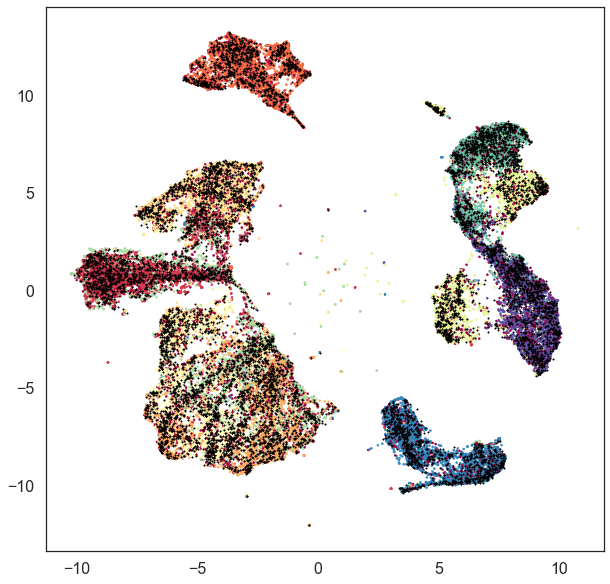

In [33]:
# model training embeddings
plt.scatter( umap_model.embedding_[:, 0], umap_model.embedding_[:, 1], c=masked_train_target, cmap='Spectral', s=4)

# superpose newly classified embeddings
plt.scatter(new_embeddings[:,0], new_embeddings[:,1], s=2, c='black')

# Mock Example Where Labels are unknown until we use HDBSCAN and Liaise with an SME

- use 50% of the fashion mnist dataset
- ignore all labels
- run UMAP
- use HDBSCAN to generate some labels
- then create a lookup dictionary between label ID and mode of operation (normal, or fault-mode A, or fault-mode B, or unknown)
- then add the label vector back into a supervised version of UMAP and save the model
- then run UMAP on a single sample from the left-out 50% of data
- use the HDBSCAN probabilities method on the result of the single sample
- connect with the mode dictionary and print the multi-class probability result
- serve in a UI with animation

Question:
Looks like I'll be able to get the cluster membership prob of the cluster it belongs to.. but how would I get the cluster membership prob of the clusters that the sample doesn't belong to?

To get the distribution of probabilities that a sample belongs to, we will need to use the soft clustering mechanism within HDBSCAN:
https://hdbscan.readthedocs.io/en/latest/soft_clustering.html

## How to get cluster membership probabilities for a (known) sample

In [151]:
import hdbscan

In [152]:
# make sure array is float64 type for this method to work
data = new_embeddings.astype('float64')

In [153]:
# must add the prediction_data true flag
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(data)

In [207]:
# 18 classes with an outlier
set(clusterer.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [208]:
import pandas as pd
pd.Series(clusterer.labels_).value_counts()

 4     2887
 6     1363
 5     1159
 9     1030
 1      958
-1      547
 2      526
 7      384
 3      382
 10     131
 14     112
 17      88
 16      87
 11      86
 15      72
 0       72
 12      46
 8       39
 13      31
dtype: int64

In [211]:
{ i:clusterer.labels_.tolist().count(i) for i in clusterer.labels_ }

{-1: 547,
 0: 72,
 1: 958,
 2: 526,
 3: 382,
 4: 2887,
 5: 1159,
 6: 1363,
 7: 384,
 8: 39,
 9: 1030,
 10: 131,
 11: 86,
 12: 46,
 13: 31,
 14: 112,
 15: 72,
 16: 87,
 17: 88}

In [155]:
# get probability distribution
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

In [156]:
soft_clusters.shape

(10000, 18)

In [213]:
soft_clusters[0]

array([0.02441998, 0.01530019, 0.0182574 , 0.0689491 , 0.01709445,
       0.14246259, 0.52393771, 0.01817679, 0.0141248 , 0.01468565,
       0.01245177, 0.01339986, 0.01636872, 0.01576438, 0.01458786,
       0.01701284, 0.01447653, 0.01519592])

In [217]:
def plot_distribution(prob_array):
    plt.figure(figsize=(8,4))
    plt.bar(
        x = range(prob_array.shape[0]),
        height = prob_array,
        tick_label = range(prob_array.shape[0])
       )

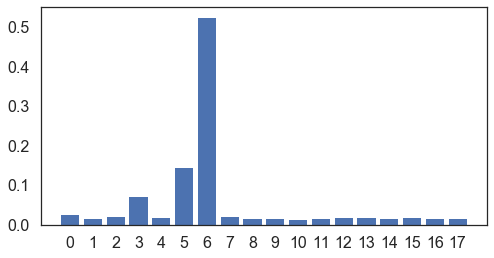

In [218]:
plot_distribution(soft_clusters[0])

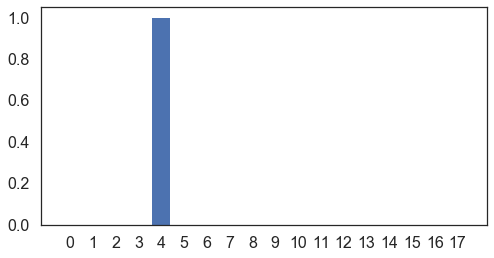

In [219]:
plot_distribution(soft_clusters[1])

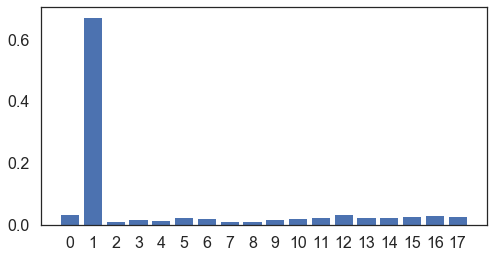

In [220]:
plot_distribution(soft_clusters[2])

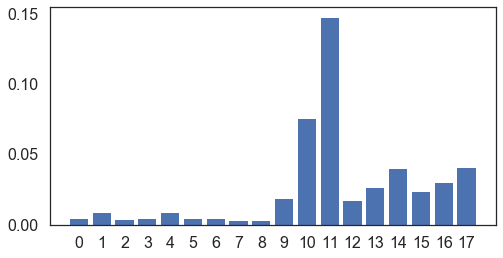

In [221]:
plot_distribution(soft_clusters[124])

## If we want to get cluster membership probabilities for an unseen sample we use the membership_vector method

In [222]:
unseen_sample = data[1000]

In [223]:
unseen_sample

array([-7.54665947, -0.35351866])

In [224]:
unseen_sample.shape

(2,)

In [225]:
data.shape

(10000, 2)

In [226]:
unseen_sample.reshape(1, -1).shape

(1, 2)

In [227]:
# the unseen sample(s) must have the same dimensionality as the data that the hdbscan object was fitted
hdbscan.membership_vector( clusterer, unseen_sample.reshape(1,-1) )

array([[0.00249546, 0.00307139, 0.0031519 , 0.00278724, 0.01577541,
        0.00258621, 0.00263565, 0.00279238, 0.00291224, 0.27988976,
        0.04453813, 0.03881734, 0.03220698, 0.04120804, 0.04605299,
        0.03615655, 0.03461174, 0.03744516]])

In [228]:
hdbscan.membership_vector( clusterer, unseen_sample.reshape(1,-1) ).shape

(1, 18)

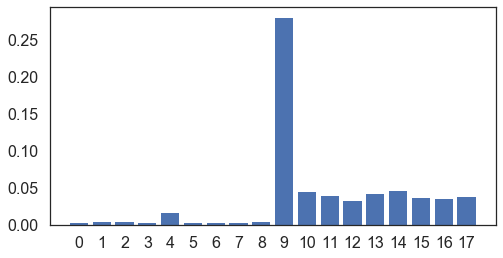

In [229]:
unseen_sample_classification = hdbscan.membership_vector( clusterer, unseen_sample.reshape(1,-1) ).reshape(-1,)

plot_distribution( unseen_sample_classification )

In [230]:
sum( unseen_sample_classification ) # ?

0.6291345719733705

This doesn't sum to 1 because of some membership being lost to the -1 outlier cluster.
In a front end we could get around this by only showing the top 5 assignments.